In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Bitte die Zelle einmal ausführen, um packages zu installieren. Kann dann auch gelöscht werden.
! pip install scikit-image==0.21.0 
# version 0.21.0

In [3]:
from Utils import *
from Evaluation import *
from Classes import ABQuadrupel
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

## Define Files to Evaluate

Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [4]:
path_to_reference_plate = r"C:\Users\Hannah\Documents\Hefekulturen\Daten\Data_May_2023\Spa2/C_Gen_D3.JPG" #r"./Data\36_MPA_ref_d3.JPG" # 
path_to_experiment_plate = r"C:\Users\Hannah\Documents\Hefekulturen\Daten\Data_May_2023\Spa2/C_Cu50_D3.JPG" #r"./Data\36_MPA_Cu0_d3.JPG"  #

save_results_folder = r"./Results_May2023/Spa2/"

In [5]:
if("A_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
elif("B_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
elif("C_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 28 

In [6]:
MIN_COLONY_SIZE = 85.0 # this is approximated by the smallest 3% in all plates 
P_VALUE_NULLHYPOTHESIS = 0.01

In [7]:
os.makedirs(save_results_folder, exist_ok=True)

## Open and Preprocess Images

### Open Images as Binary

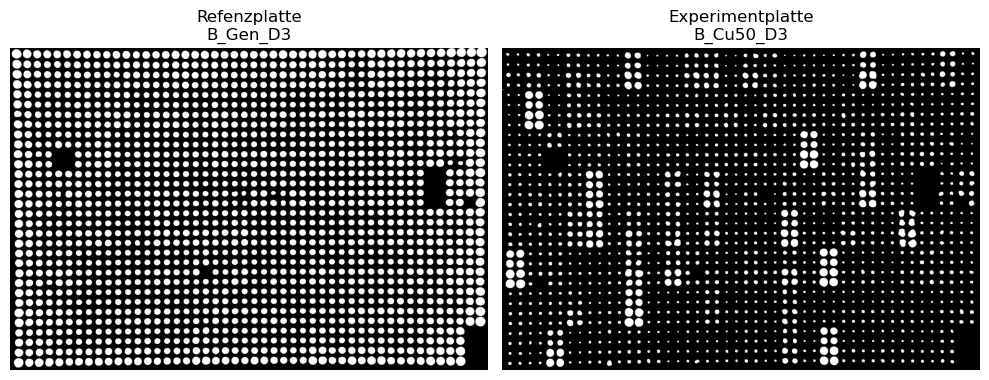

In [8]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### Compute Colony Sizes



#### Automatic

Please set `x_expected` to the number of colonies visible in the x-Axis (width) 

Please set `y_expected` to the number of colonies visible in the y-Axis (height) 

Please only set `USE_HARD_GRID` to `True` if the grid is not working properly.

In [9]:
USE_HARD_GRID = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


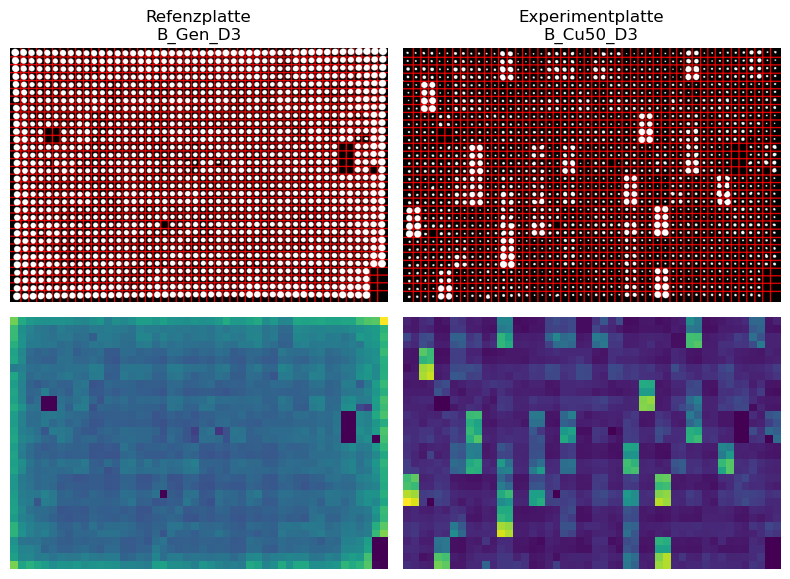

In [10]:
rgb_grid_reference, sizes_reference, x_start, x_end, y_start, y_end = compute_grid(reference_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)
rgb_grid_experiment, sizes_experiment, x_start, x_end, y_start, y_end = compute_grid(experiment_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)

if((not np.any(rgb_grid_reference == None)) and (not np.any(rgb_grid_experiment == None))):
    fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
    axs[0,0].imshow(rgb_grid_reference)
    axs[0,1].imshow(rgb_grid_experiment)
    axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
    axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
    axs[0,0].set_axis_off()
    axs[0,1].set_axis_off()

    axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
    axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
    axs[1,0].set_axis_off()
    axs[1,1].set_axis_off()
    plt.tight_layout()
    plt.autoscale(False)
    plt.show()



## Evaluate
- Normalize experimental plate in relation to reference plate
- Find invalid quadruples
- Find siginificant differences between row A and row B
- Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple is larger than median of reference plate
- Saves .pdf into results folder with images

**Open questions: Currently sizes > median of reference plate but probably mean growth of quadruple > than mean growth of corresponting quadruple on the reference plate?**

Therefore adapt `PERCENTILE` to a value in tange 0-100 and test for the best fitting one.

If `PERCENTILE` is set to -1, use outlier detection.

To generate a broad understanding of the p-value and its meaning in statistics, please read: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5665734/

In [11]:
PERCENTILE = -1

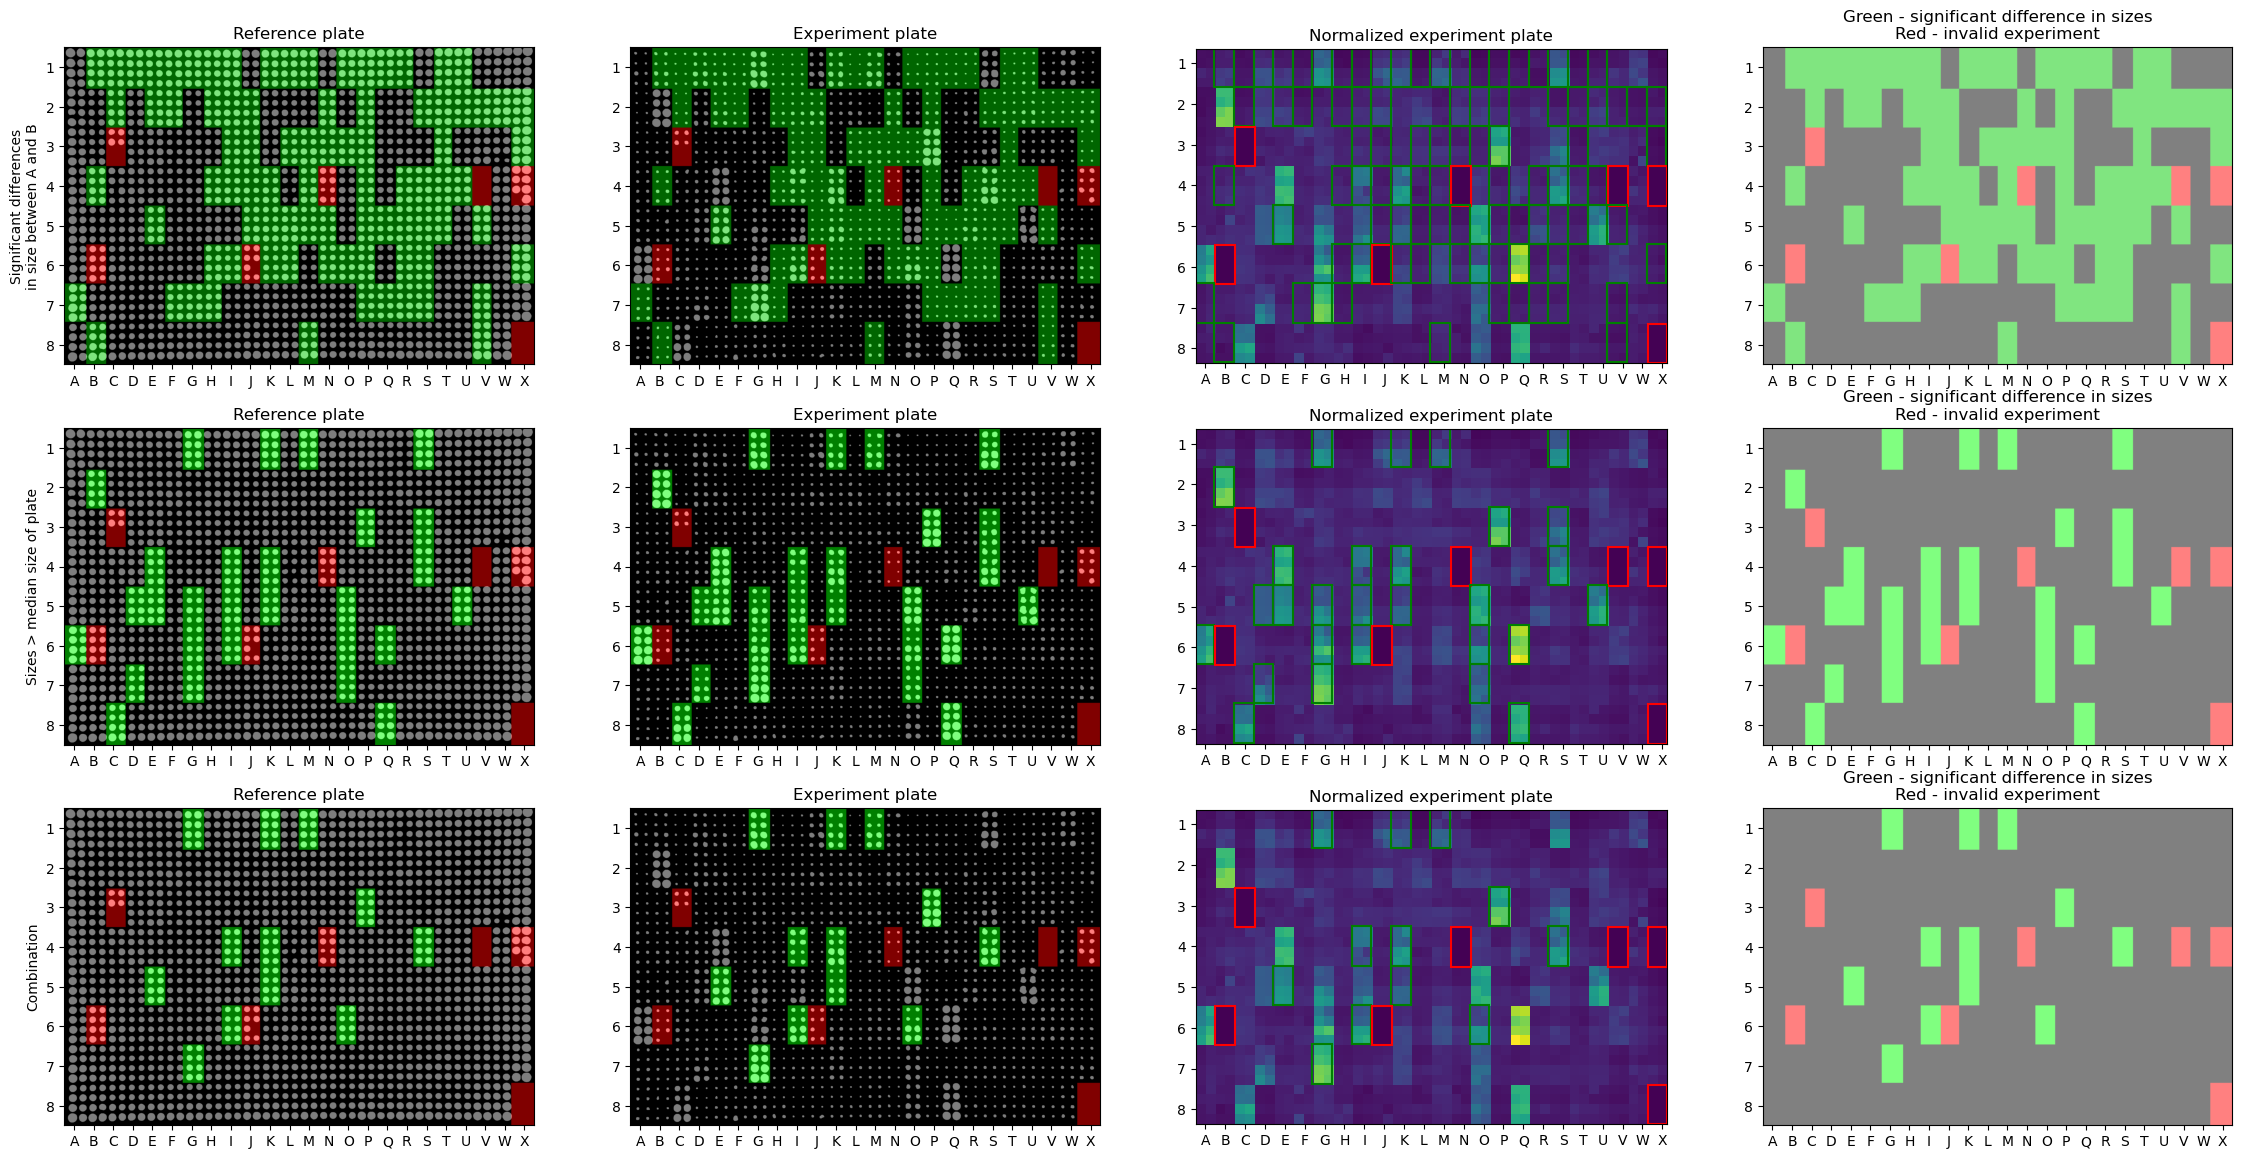

In [12]:
quadruples = evaluate(experiment_plate, reference_plate, sizes_experiment, sizes_reference, x_start, x_end, y_start, y_end, MIN_COLONY_SIZE, P_VALUE_NULLHYPOTHESIS, PERCENTILE, log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## Save Data to Excel Sheet

In [13]:
data = {'position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'name': [str(quad.name) for quad in quadruples], 
        'p-value': [quad.p_value for quad in quadruples], 
        'effect size': [quad.effect_size for quad in quadruples], 
        'bigger than percentile': [quad.bigger_than_median for quad in quadruples],
        'is valid' : [quad.is_valid for quad in quadruples], 
        'bigger row': [quad.bigger_row for quad in quadruples],

        'diff mean size': [quad.diff_growth for quad in quadruples],        
        'max mean size': [quad.max_mean_growth for quad in quadruples],
        'min mean size': [quad.min_mean_growth for quad in quadruples],
        'sizes A': [str(quad.quadrupelA.sizes) for quad in quadruples], 
        'sizes B': [str(quad.quadrupelB.sizes) for quad in quadruples],
        'ordinal scale': [quad.ordinal_scale for quad in quadruples]}
df = pd.DataFrame(data=data)    

df = df.sort_values(by=['ordinal scale'], ascending=False)
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")
df

,position,name,p-value,effect size,bigger than percentile,is valid,bigger row,diff mean size,max mean size,min mean size,sizes A,sizes B,ordinal scale
0,O 6,,0.000074,28.151026,True,True,B,0.681936,1.126373,0.444437,[0.41878368 0.49323787 0.44070648 0.42502142],[1.14817367 1.12630015 1.09888579 1.13213213],369
1,I 6,,0.000047,9.951739,True,True,B,0.650841,1.291092,0.640251,[0.56782609 0.6054007 0.68154506 0.70623399],[1.23016997 1.21934128 1.3125 1.40235814],360
2,K 5,,0.000898,13.008949,True,True,B,0.323549,0.725777,0.402228,[0.37326121 0.40793413 0.37257824 0.45513866],[0.72254711 0.7287706 0.73966102 0.71213115],356
3,G 1,,0.000743,8.500860,True,True,B,0.416273,1.116242,0.699970,[0.74155496 0.64703132 0.67322404 0.73806881],[1.13205418 1.02467685 1.17626527 1.13197361],344
4,E 5,,0.000017,7.875540,True,True,B,0.182899,1.158144,0.975245,[0.98134328 0.94619799 1.01050263 0.96293551],[1.15644556 1.12860438 1.19214502 1.15538089],341
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,U 1,,0.001232,4.826893,False,True,B,0.096559,0.204672,0.108114,[0.0858748 0.10986367 0.11618468 0.12053115],[0.17067711 0.19096844 0.22982063 0.22722222],-1
73,Q 5,,0.000439,9.126954,False,True,B,0.103196,0.205549,0.102353,[0.09975865 0.11529027 0.09983498 0.09452736],[0.18985396 0.22018349 0.21872864 0.19343066],-1
74,B 3,,0.350388,0.895774,False,True,B,0.031472,0.209375,0.177903,[0.14992826 0.22067268 0.17329545 0.16771488],[0.26510574 0.2316129 0.18617344 0.1546073 ],-1
75,M 2,,0.011031,5.948605,False,True,B,0.079805,0.211561,0.131756,[0.14198783 0.11476557 0.12594841 0.14432177],[0.21541377 0.21954485 0.22443377 0.18685121],-1
